<a href="https://colab.research.google.com/github/Ambaright/ST-554-Project1/blob/main/Task3/ST554_Project_1_Task_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 1 — Task 3: Time Series Cross-Validation for Benzene Prediction

*Programmed by: Michelle Silveira*

## Introduction

The increasing incidence of respiratory illness and the known carcinogenic risks associated with prolonged exposure to pollutants like benzene (`C6H6(GT)`) have made precise urban air quality monitoring a critical priority for public health and municipal traffic management. Currently, urban monitoring relies on sparse networks of fixed stations equipped with high-precision industrial spectrometers; however, the high cost and significant size of these instruments prevent the deployment of a monitoring mesh dense enough to capture the complex, turbulent diffusion of gases in a city environment. To address this gap, research has shifted toward low-cost gas multi-sensor devices, often termed "electronic noses," which utilize solid-state sensors to provide a more granular view of urban pollution.

The dataset examined here comes from a 13-month measurement campaign (March 2004 to April 2005) conducted along a high-traffic road in an Italian city. The study's primary objective was to evaluate the feasibility of using low-cost devices to supplement existing monitoring networks by comparing their readings against "Ground Truth" (GT) reference data from a conventional monitoring station. The dataset includes hourly mean concentrations for several true pollutants — CO, NMHC, C6H6, NOx, and NO2 — recorded alongside the responses of five metal oxide chemoresistive sensors and weather-related variables including temperature (`T`), relative humidity (`RH`), and absolute humidity (`AH`).

The goal of this task is to evaluate how well two competing regression models can **predict daily average benzene concentrations** from other measured variables. The two models considered are:

- **Simple Linear Regression (SLR):** A statistical method that models the relationship between a single predictor variable and a response. Here, `CO(GT)` (carbon monoxide concentration) is used as the sole predictor of `C6H6(GT)` (benzene). SLR assumes a straight-line relationship of the form `y = b0 + b1*x`.
- **Multiple Linear Regression (MLR):** An extension of SLR that incorporates multiple predictor variables simultaneously to explain variation in the response. Here, `CO(GT)`, `T`, `RH`, and `AH` are all used together as predictors of benzene. MLR can capture more complex relationships and may improve predictions if the additional variables carry useful information about benzene levels.

To evaluate these models fairly, we use a **time-series cross-validation** approach. Standard cross-validation randomly splits data into training and testing sets, but this is inappropriate here because our observations are ordered in time — days close together tend to be correlated. Randomly shuffling them would allow future information to leak into the past, giving an overly optimistic picture of model performance. Instead, we use an **expanding-window sequential CV**: we train on the first 250 days, predict day 251, then train on the first 251 days, predict day 252, and so on until the final day. The one-step-ahead prediction errors are summed to produce an overall measure of each model's predictive ability, and the model with the lower cumulative error is selected as the best model and fit to the full dataset.

**Reading in the Data**
In this section, the data is read in from [Air Quality Data](https://archive.ics.uci.edu/dataset/360/air+quality) and the features are extracted and stored into a saved DataFrame air. We then investigate the data to understand how it is stored using .head() and .info() methods. With .head() we can see what the first five rows of our data look like, and with .tail() we can see what the last five rows of our data look like. With .info() we can see the data types for each variable.

In [2]:
# Install ucimlrepo if you haven't already
!pip install ucimlrepo

from ucimlrepo import fetch_ucirepo

# Fetch dataset
air_quality = fetch_ucirepo(id=360)

# Extract the Features
air = air_quality.data.features
print(".head()")
print(air.head())
print("\n" + ".tail()")
print(air.tail())



.head()
        Date      Time  CO(GT)  PT08.S1(CO)  NMHC(GT)  C6H6(GT)  \
0  3/10/2004  18:00:00     2.6         1360       150      11.9   
1  3/10/2004  19:00:00     2.0         1292       112       9.4   
2  3/10/2004  20:00:00     2.2         1402        88       9.0   
3  3/10/2004  21:00:00     2.2         1376        80       9.2   
4  3/10/2004  22:00:00     1.6         1272        51       6.5   

   PT08.S2(NMHC)  NOx(GT)  PT08.S3(NOx)  NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)  \
0           1046      166          1056      113          1692         1268   
1            955      103          1174       92          1559          972   
2            939      131          1140      114          1555         1074   
3            948      172          1092      122          1584         1203   
4            836      131          1205      116          1490         1110   

      T    RH      AH  
0  13.6  48.9  0.7578  
1  13.3  47.7  0.7255  
2  11.9  54.0  0.7502  
3  11.0  60.0  0.7

In [3]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error


## Data Cleaning

Before we can fit models or run cross-validation, the data must be cleaned and restructured. This involves two main steps.

First, we remove any observations where the key variables — `C6H6(GT)`, `CO(GT)`, `T`, `RH`, or `AH` — are equal to `-200`. As established in the earlier tasks of this project, `-200` is used as a sentinel value in this dataset to represent missing measurements, and including these would distort both our model fits and our predictions.

Second, we aggregate the cleaned hourly observations up to the **daily level** by computing the mean of each variable within each calendar date. This produces one row per day, converting our hourly time series into a daily time series. A `Day` variable is also created, taking integer values 1 through 347 to give each date a simple sequential index. This daily dataset is what we will use for all modeling and cross-validation below.


In [4]:
# Drop columns that are entirely missing (often trailing empty columns from the UCI file)
df = air
df = df.dropna(axis=1, how="all")

# Define the key columns we need for this task
needed_cols = ["C6H6(GT)", "CO(GT)", "T", "RH", "AH"]

# Keep only rows where none of these columns equals -200 (the missing value sentinel)
df_clean = df[(df[needed_cols] != -200).all(axis=1)].copy()

print("Rows after removing -200 values:", df_clean.shape[0])

Rows after removing -200 values: 7344


In [5]:
# Create daily averages by grouping on Date
daily_df = (
    df_clean.groupby("Date")[needed_cols]
    .mean()
    .reset_index()
)

# Convert Date to a proper datetime type and sort chronologically
daily_df["Date"] = pd.to_datetime(daily_df["Date"], format="%m/%d/%Y")
daily_df = daily_df.sort_values("Date").reset_index(drop=True)

# Create a sequential Day variable (1 through 347) after sorting
daily_df["Day"] = range(1, len(daily_df) + 1)

print("Number of days in daily dataset:", daily_df.shape[0])
print("\nFirst five rows of the daily dataset:")
daily_df.head()

Number of days in daily dataset: 347

First five rows of the daily dataset:


,Date,C6H6(GT),CO(GT),T,RH,AH,Day
0,2004-03-10,8.450000,1.966667,12.033333,54.900000,0.765633,1
1,2004-03-11,8.269565,2.239130,9.826087,64.230435,0.777039,2
2,2004-03-12,12.177273,2.804545,11.618182,50.190909,0.665164,3
3,2004-03-13,11.121739,2.695652,13.121739,50.682609,0.733013,4
4,2004-03-14,9.830435,2.469565,16.182609,48.317391,0.849209,5


## Defining the Models' Predictor and Response Variables

With the daily dataset prepared, we now define the response variable and the two sets of predictors for our competing models. The response variable `y` is the daily average benzene concentration, `C6H6(GT)`. For the SLR model, the predictor matrix `X_slr` contains only `CO(GT)`. For the MLR model, the predictor matrix `X_mlr` contains `CO(GT)`, `T` (temperature), `RH` (relative humidity), and `AH` (absolute humidity). Both predictor matrices are kept as DataFrames so they can be passed directly to scikit-learn's `LinearRegression` model.

In [6]:
# Response variable: daily average benzene concentration
y = daily_df["C6H6(GT)"]

# SLR predictors: CO(GT) only
X_slr = daily_df[["CO(GT)"]]

# MLR predictors: CO(GT), temperature, relative humidity, absolute humidity
X_mlr = daily_df[["CO(GT)", "T", "RH", "AH"]]

## Time-Series Cross-Validation Functions

To implement the expanding-window cross-validation, we write two functions. The first is a **helper function** called `one_step_mse`, which performs a single step of the procedure: it trains a linear regression model on all days up to and including a specified day, predicts the very next day's benzene concentration, and returns the mean squared error (MSE) between the prediction and the actual value. MSE is defined as the squared difference between the predicted and observed value — in a one-observation test set this is simply `(y_pred - y_actual)²`.

The second function, `rolling_cv_full`, calls the helper repeatedly over all days starting from a chosen initial training window (day 250 in our case) up through the second-to-last day in the dataset. At each step, it accumulates the MSE values. The function returns the total summed MSE (our primary comparison metric), the average MSE per step, and the full list of per-step MSE values for plotting. A lower total MSE indicates a model that produces more accurate one-step-ahead predictions across the evaluation period.

In [7]:
def one_step_mse(X, y, day):
    """
    Compute one-step-ahead MSE using an expanding training window.

    Parameters
    ----------
    X : pd.DataFrame
        Predictor data in time order (one row per day).
    y : pd.Series
        Response in time order (one value per day).
    day : int
        The number of rows to include in the training set (iloc-based).
        The test set is the single row immediately following.

    Returns
    -------
    float
        Mean squared error for predicting the day+1 observation
        from a model trained on rows 0 through day-1.
    """
    # Training set: all rows up to (but not including) index `day`
    X_train = X.iloc[:day]
    y_train = y.iloc[:day]

    # Test set: the single row at index `day`
    X_test = X.iloc[day:day+1]
    y_test = y.iloc[day:day+1]

    # Fit a linear regression model to the training data
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Predict on the test observation and compute MSE
    y_pred = model.predict(X_test)

    return mean_squared_error(y_test, y_pred)

In [8]:
def rolling_cv_full(X, y, start_day=250):
    """
    Perform expanding-window time-series cross-validation.

    Starting from `start_day`, iterates through all days up to the
    second-to-last, calling one_step_mse at each step and accumulating
    the total MSE.

    Parameters
    ----------
    X : pd.DataFrame
        Predictor data in time order.
    y : pd.Series
        Response variable in time order.
    start_day : int
        The size of the initial training window (default 250).

    Returns
    -------
    total_mse : float
        The sum of all one-step-ahead MSE values.
    avg_mse : float
        The average one-step-ahead MSE across all evaluation steps.
    step_mse : list of float
        The individual MSE value at each prediction step.
    """
    n_days = len(X)       # total number of days (determined from data, not hardcoded)
    total_mse = 0.0
    step_mse = []

    # Iterate from start_day to the second-to-last day
    for day in range(start_day, n_days):
        mse = one_step_mse(X, y, day)
        step_mse.append(mse)
        total_mse += mse   # accumulate MSE using augmented assignment

    avg_mse = total_mse / len(step_mse)

    return total_mse, avg_mse, step_mse

## Running Cross-Validation for Both Models

We now run the cross-validation procedure for both the SLR and MLR models, using the first 250 days as the initial training window. For each model, `rolling_cv_full` returns the total summed MSE, the average per-step MSE, and the list of individual step errors. The total MSE is our primary metric for comparing the two models: the model with the lower total MSE is considered to have better predictive performance across the evaluation period.

In [9]:
# Run cross-validation for SLR (CO only)
total_slr, avg_slr, steps_slr = rolling_cv_full(X_slr, y, start_day=250)

# Run cross-validation for MLR (CO + T + RH + AH)
total_mlr, avg_mlr, steps_mlr = rolling_cv_full(X_mlr, y, start_day=250)

print("SLR (CO only)")
print("  Total MSE:", round(total_slr, 4))
print("  Average MSE per step:", round(avg_slr, 4))

print("\nMLR (CO + T + RH + AH)")
print("  Total MSE:", round(total_mlr, 4))
print("  Average MSE per step:", round(avg_mlr, 4))

SLR (CO only)
  Total MSE: 718.081
  Average MSE per step: 7.4029

MLR (CO + T + RH + AH)
  Total MSE: 494.3422
  Average MSE per step: 5.0963


## Model Comparison and Selection

Comparing the total CV MSE values for the two models tells us which set of predictors leads to better out-of-sample predictions. If the MLR model (which uses CO, temperature, relative humidity, and absolute humidity) achieves a lower total MSE than the SLR model (which uses only CO), it means the weather variables add meaningful predictive power for benzene beyond what CO alone can provide. This would make intuitive sense: benzene diffuses differently under different atmospheric conditions, so temperature and humidity could reasonably help explain variation in daily benzene levels.

Conversely, if the SLR and MLR perform similarly, it would suggest that CO concentration is the dominant predictor of benzene in this dataset, and the added complexity of the MLR model does not pay off in terms of prediction accuracy.

Based on the CV results above, the model with the lower total MSE is selected as the best model. It is then fit on the **entire 347-day dataset** to obtain the final regression coefficients, which can be used for prediction going forward.

In [10]:
# Select the best model based on total CV MSE
if total_mlr < total_slr:
    X_best = X_mlr
    best_name = "MLR: CO(GT) + T + RH + AH"
else:
    X_best = X_slr
    best_name = "SLR: CO(GT) only"

# Fit the best model to the full dataset
final_model = LinearRegression()
final_model.fit(X_best, y)

print("Best model based on rolling CV:", best_name)
print("Intercept:", round(final_model.intercept_, 4))
print("Coefficients:", {k: round(v, 4) for k, v in zip(X_best.columns, final_model.coef_)})

Best model based on rolling CV: MLR: CO(GT) + T + RH + AH
Intercept: -1.8378
Coefficients: {'CO(GT)': np.float64(4.7708), 'T': np.float64(0.1197), 'RH': np.float64(-0.0162), 'AH': np.float64(0.6887)}


## Additional Analysis: Visualizing Prediction Error Over Time

To gain additional insight into how each model performs across the evaluation period, we plot the one-step-ahead prediction error (MSE and RMSE) at each time step for both models. The RMSE plots are especially informative because RMSE is expressed in the same units as benzene (`µg/m³`), making the errors easier to interpret in practical terms. Peaks in these plots indicate days where either model struggled to predict accurately — these may correspond to unusual weather events, seasonal transitions, or other sudden changes in air quality conditions.

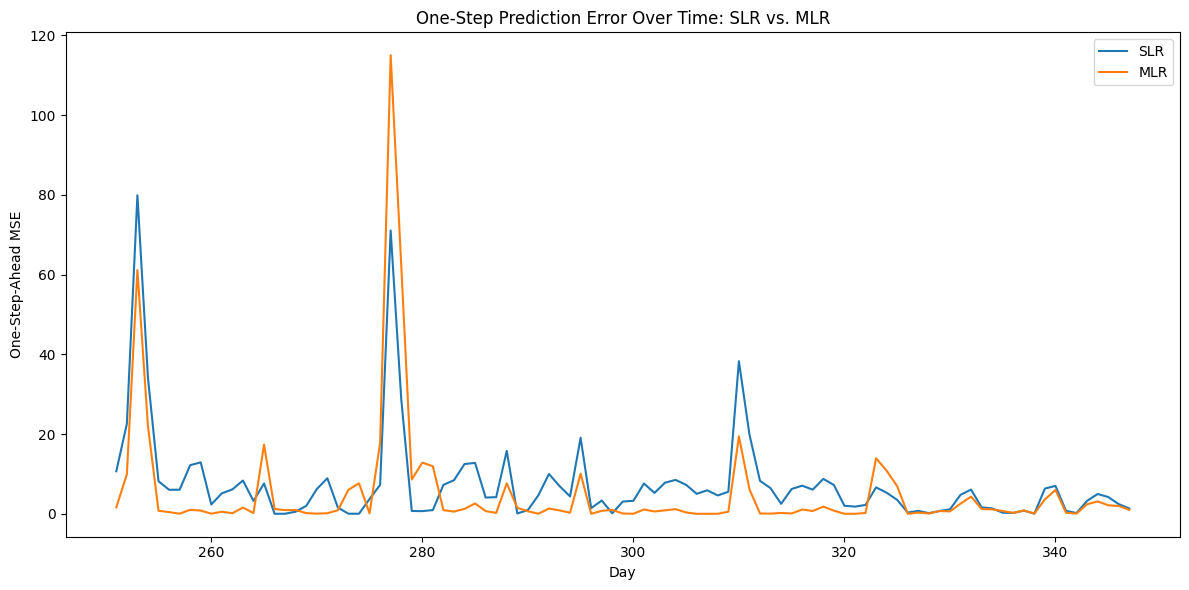

In [11]:
import matplotlib.pyplot as plt

# Plot one-step-ahead MSE over time for both models
plt.figure(figsize=(12, 6))
plt.plot(range(251, 251 + len(steps_slr)), steps_slr, label="SLR")
plt.plot(range(251, 251 + len(steps_mlr)), steps_mlr, label="MLR")
plt.xlabel("Day")
plt.ylabel("One-Step-Ahead MSE")
plt.title("One-Step Prediction Error Over Time: SLR vs. MLR")
plt.legend()
plt.tight_layout()
plt.show()

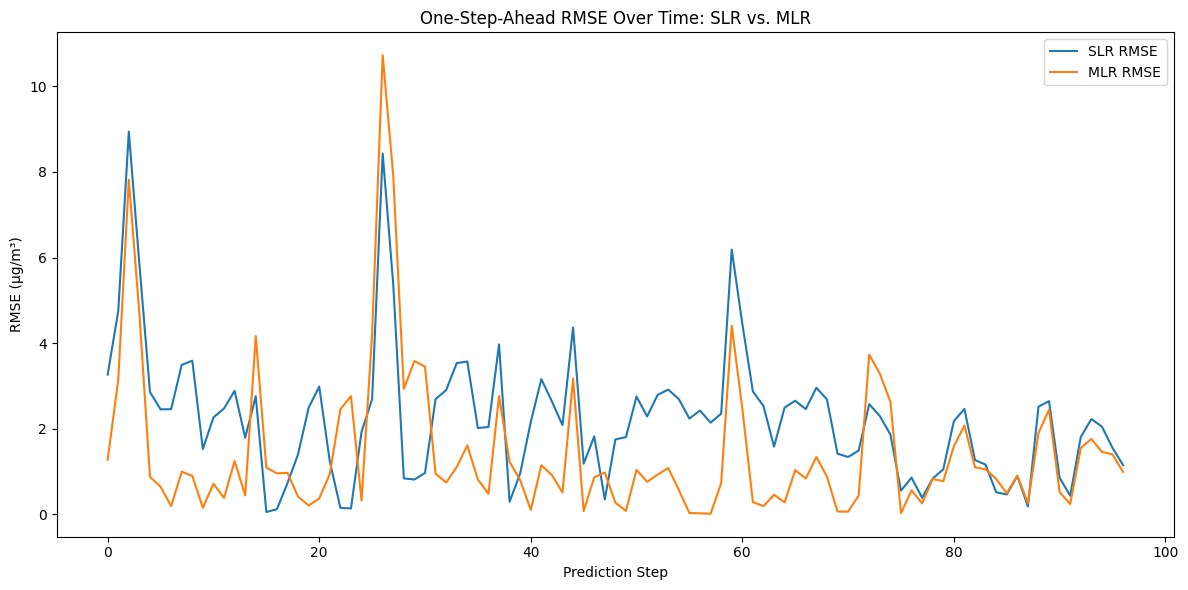

In [12]:
# Convert MSE to RMSE for a more interpretable scale (units: µg/m³)
rmse_slr = np.sqrt(pd.Series(steps_slr))
rmse_mlr = np.sqrt(pd.Series(steps_mlr))

plt.figure(figsize=(12, 6))
plt.plot(rmse_slr.values, label="SLR RMSE")
plt.plot(rmse_mlr.values, label="MLR RMSE")
plt.xlabel("Prediction Step")
plt.ylabel("RMSE (µg/m³)")
plt.title("One-Step-Ahead RMSE Over Time: SLR vs. MLR")
plt.legend()
plt.tight_layout()
plt.show()